In [1]:
%matplotlib inline

In [2]:
!hostname

mum-hpc2-gpu1


In [3]:
%cd ICRA_2023

/home/ssap0002/ICRA_2023


In [6]:
from VRNN_DAT import VRNN_DAT
from RNN import GRU, LSTM

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt 

## Data Loading

In [7]:
import os
import numpy as np
import pickle5 as pickle
from sklearn.preprocessing import MinMaxScaler, StandardScaler

ORI_DATA_DIR = 'data/gripper/full'
HALF_DATA_DIR = 'data/gripper/half'
SYNTH_DATA_DIR = 'output/'

In [26]:
def to_timeseries(X, y, time_steps = 50):
    dataX = []
    dataY = []
    # Cut data by sequence length
    for i in range(0, len(X) - time_steps):
        _x = X[i:i+time_steps, :]
        _y = y[i:i+time_steps, :]
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

def revert_timeseries(X, time_steps = 100):
  # if len(X[0]) == time_steps and time_steps != 1:
  #   return np.array(X[0])
  head = X[0]
  tail = np.array([f[time_steps-1] for f in X])
  return np.concatenate((head, tail))

def load_pickle(filepath):
    with open(filepath,'rb') as f:
      x = pickle.load(f)
      return x
    
def _preprocess(data):
  # Features
  flex = data['Flex'][0]
  pressure = data['Pressure'][0]

  # Labels
  f1, f2 = data['Force']
  x1, x2, x3, x4, x5, x6, x7, x8, x9, x10 = data['PosX']
  y1, y2, y3, y4, y5, y6, y7, y8, y9, y10 = data['PosY']
      
  x = list(zip(flex, pressure, f1, f2, x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, y1, y2, y3, y4, y5, y6, y7, y8, y9, y10))
  return np.array(x)

def shuffle(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def load_data(s, _from='Train', scaler=None):
  raw_data = load_pickle("data/new_soro_all.pkl")
  train = raw_data.xs(_from, axis=0, level=1, drop_level=True)

  raw_data = _preprocess(train[s])

  # Normalize 
  if scaler is None:
      label_scaler = MinMaxScaler()
      feature_scaler = MinMaxScaler()
    
      features, labels = feature_scaler.fit_transform(raw_data[:, :2]), label_scaler.fit_transform(raw_data[:, 2:])
  else:
    label_scaler, feature_scaler = scaler
    features, labels = feature_scaler.transform(raw_data[:, :2]), label_scaler.transform(raw_data[:, 2:])
    

  # Timeseries
  X_train, y_train = to_timeseries(features, labels, params['timesteps'])

  return  X_train, y_train, (label_scaler, feature_scaler)

In [11]:
def load_dataset(datatype, datasets, batch_size, no_state_data=[]):
    X_train, y_train, domain_labels = [], [], []
    scaler = None
    
    if datatype == 'test':
        for scenario in datasets:
            _x, _y, scaler = load_data(scenario, _from='Test', scaler=scaler)
            X_train.append(np.array(_x).astype('float32')), y_train.append(np.array(_y).astype('float32'))
            if scenario in no_state_data:
                domain_labels.append([0 for _ in range(len(_x))])
            else:
                domain_labels.append([1 for _ in range(len(_x))])

        for i, (x,y) in enumerate(zip(X_train, y_train)):
            if i == 0:
                dataset = tf.data.Dataset.from_tensor_slices((x, y, domain_labels[i]))
                dataset = dataset.batch(batch_size)
            
            else: 
                _d = tf.data.Dataset.from_tensor_slices((x, y, domain_labels[i]))
                _d = _d.batch(batch_size)
                dataset = dataset.concatenate(_d)
        return dataset, scaler
    
    elif datatype == 'train':
        for scenario in datasets:
            _x, _y, scaler = load_data(scenario, _from='Train', scaler=scaler)
            X_train.append(np.array(_x).astype('float32')), y_train.append(np.array(_y).astype('float32'))
            if scenario in no_state_data:
                domain_labels.append([0 for _ in range(len(_x))])
            else:
                domain_labels.append([1 for _ in range(len(_x))])

        Xdata = np.concatenate(X_train)
        ydata = np.concatenate(y_train)
        Statedata = np.concatenate(domain_labels).astype(np.float32)

        # Shuffle
        p = np.random.permutation(len(Xdata))
        Xdata = Xdata[p]
        ydata = ydata[p]
        Statedata = Statedata[p]

        dataset =  tf.data.Dataset.from_tensor_slices((Xdata ,ydata, Statedata))
        return dataset.batch(batch_size), scaler

In [16]:
def get_dataset(model_type, train_scenario, batch_size):
    all_datasets = ['osc_tip_30', 'rand_tip_30', 'osc_rand_30', 'rand_rand_60']
    
    if train_scenario == "tip_contact":
        _train_d = ['osc_tip_30', 'rand_tip_30']
    elif train_scenario == "random_contact":
        _train_d = ['osc_rand_30', 'rand_rand_60']
    
    _test_d = [d for d in all_datasets if d not in _train_d]
    
    test_dataset, (label_scaler, feature_scaler) = load_dataset('test', _test_d, batch_size)
        
    if model_type == "GRU" or model_type == "LSTM":           
        train_dataset, _ = load_dataset('train', _train_d, batch_size)
    
    elif model_type == "VRNN_DAT":
        train_dataset, _ = load_dataset('train', all_datasets, batch_size, no_state_data=_test_d)
    
    return train_dataset, test_dataset, (label_scaler, feature_scaler)

def get_model(model_type, params=None):
    if model_type == "GRU":
        return GRU(params['x_dim'], params['timesteps'], params['z_dim'], params['h_dim'])
    elif model_type == "LSTM":
        return LSTM(params['x_dim'], params['timesteps'], params['z_dim'], params['h_dim'])
    elif model_type == "VRNN":
        pass
    elif model_type == "VRNN_DAT":
        return VRNN_DAT(params['x_dim'], params['h_dim'], params['z_dim'], phi_x_dim=params['phi_x_dim'], d_dim=params['d_dim'], vrnn_lr=params['lr'], adv_lr=params['adv_lr'], clip=params['clip'])

def evaluate_model(model, test_dataset):
    pred, y_test = [], []
    for step, (x_batch_test, y_batch_test, _) in enumerate(test_dataset):
        _pred = model.predict(x_batch_test)
        pred.append(_pred)
        y_test.append(y_batch_test)
        
    pred = np.concatenate(pred)
    y_test = np.concatenate(y_test)
    
    force_x_rmse_metric = tf.keras.metrics.RootMeanSquaredError()
    force_z_rmse_metric = tf.keras.metrics.RootMeanSquaredError()
    marker_rmse_metric = tf.keras.metrics.RootMeanSquaredError()
    
    force_x_rmse_metric.update_state(y_test[:, :, 0], pred[:, :, 0]).numpy()
    force_z_rmse_metric.update_state(y_test[:, :, 1], pred[:, :, 1]).numpy()
    
    force_rmse = (force_x_rmse_metric.result().numpy(), force_z_rmse_metric.result().numpy())

    marker_rmse_metric.update_state(y_test[:, :, 2:], pred[:, :, 2:]).numpy()
    marker_rmse = marker_rmse_metric.result().numpy()
    
    return force_rmse, marker_rmse

## Hyperparameters

In [17]:
x_dim = 2 # flex + pressure
h_dim = 128
z_dim = 22 # 2 force + 10*2D coordinates
phi_x_dim = 32
d_dim = 128
n_epochs = 50
clip = 5
lr = 1e-3
adv_lr = 1e-3
batch_size = 128 # 32
seed = 261199
timesteps=100
# tf.random.set_seed(seed)

In [18]:
from sorcery import dict_of

params = dict_of(x_dim, h_dim, z_dim, phi_x_dim, timesteps, d_dim, n_epochs, clip, lr, adv_lr, batch_size)

## Train Models

In [19]:
model_types = ["GRU"]
scenarios = ['tip_contact']
df = pd.DataFrame(columns=["Model", "Train Scenario", "Force_X_RMSE", "Force_Z_RMSE", "Marker_RMSE", "Run"])
                  
for model_type in model_types:
    for train_scenario in scenarios:
        for run in range(1, 2):
            print(f"================={model_type}:{train_scenario}:{run}==================")
            # Prepare dataset and model
            train_dataset, test_dataset, scalers = get_dataset(model_type, train_scenario, params['batch_size'])
            model = get_model(model_type, params)

           # Train
            if model_type == "GRU" or model_type == "LSTM":
                model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.RootMeanSquaredError()])
            else:
                model.compile()
            model.fit(train_dataset, epochs=params['n_epochs'], batch_size=params['batch_size'])

            # Save weights
            # model.save_weights(f"weights/{model_type}/{train_scenario}/run_{run}/")

            # Evaluate
            (force_x_rmse, force_z_rmse), marker_rmse = evaluate_model(model, test_dataset)

            # Write to df
            df = df.append({"Model": model_type, "Train Scenario": train_scenario, 'Force_X_RMSE': force_x_rmse, 'Force_Z_RMSE': force_z_rmse, 'Marker_RMSE': marker_rmse, "Run": run}, ignore_index=True)
            
            print(f"================={model_type}:{train_scenario}:{run}:{force_x_rmse}:{force_z_rmse}:{marker_rmse}==================")

=================GRU:tip_contact:1==================
Epoch 1/50


2022-09-05 17:03:32.792233: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-09-05 17:03:32.936551: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


233/233 [==============================] - 4s 5ms/step - loss: 0.0248 - root_mean_squared_error: 0.1573
Epoch 2/50
233/233 [==============================] - 1s 5ms/step - loss: 0.0101 - root_mean_squared_error: 0.1003
Epoch 3/50
233/233 [==============================] - 1s 5ms/step - loss: 0.0089 - root_mean_squared_error: 0.0944
Epoch 4/50
233/233 [==============================] - 1s 5ms/step - loss: 0.0083 - root_mean_squared_error: 0.0913
Epoch 5/50
233/233 [==============================] - 1s 5ms/step - loss: 0.0081 - root_mean_squared_error: 0.0898
Epoch 6/50
233/233 [==============================] - 1s 5ms/step - loss: 0.0079 - root_mean_squared_error: 0.0888
Epoch 7/50
233/233 [==============================] - 1s 5ms/step - loss: 0.0077 - root_mean_squared_error: 0.0879
Epoch 8/50
233/233 [==============================] - 1s 5ms/step - loss: 0.0076 - root_mean_squared_error: 0.0871
Epoch 9/50
233/233 [==============================] - 1s 5ms/step - loss: 0.0074 - root_mea

/tmp/ipykernel_1813440/3868620024.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Model": model_type, "Train Scenario": train_scenario, 'Force_X_RMSE': force_x_rmse, 'Force_Z_RMSE': force_z_rmse, 'Marker_RMSE': marker_rmse, "Run": run}, ignore_index=True)


In [20]:
df

,Model,Train Scenario,Force_X_RMSE,Force_Z_RMSE,Marker_RMSE,Run
0,GRU,tip_contact,0.208541,0.257995,0.255452,1


In [21]:
GRU = model

In [22]:
# df.to_csv('rnn_results.csv', index=False)

In [23]:
train_dataset, test_dataset, scalers = get_dataset("GRU", scenarios[0], params['batch_size'])

In [24]:
plt.style.use('seaborn')
def plot(axes, model, color='blue', l="label", vrnn=False, run=0):
    pred, y_test = [] , []
    for step, (x_batch_test, y_batch_test, state_available) in enumerate(test_dataset):
        if not vrnn:
            _pred = model.predict(x_batch_test, verbose=0)
        else:
            _pred = model.predict(x_batch_test)
            
        pred.append(_pred)
        y_test.append(y_batch_test)

    pred = np.concatenate(pred)
    y_test = np.concatenate(y_test)

    pred = revert_timeseries(pred, timesteps)
    
    # predicted_arr = revert_scaling(scalers, pred)
    
    predicted_arr = scalers[0].inverse_transform(pred)
    
    
        
    a1,a2,a3,a4 = axes
    # if vrnn:
    # predicted_arr[:, 1] = predicted_arr[:, 1]+0.5
    
    x = 0.1*np.arange(np.shape(predicted_arr[:])[0])

    a1.plot(x, predicted_arr[:, 0], label=l, linewidth=1, color=color)

    a2.plot(x, predicted_arr[:, 1], label=l, linewidth=1, color=color)
           

    a3.plot(x, predicted_arr[:, 11], label=l, linewidth=1, color=color)

    a4.plot(x, predicted_arr[:, -1], label=l, linewidth=1, color=color)

    return predicted_arr

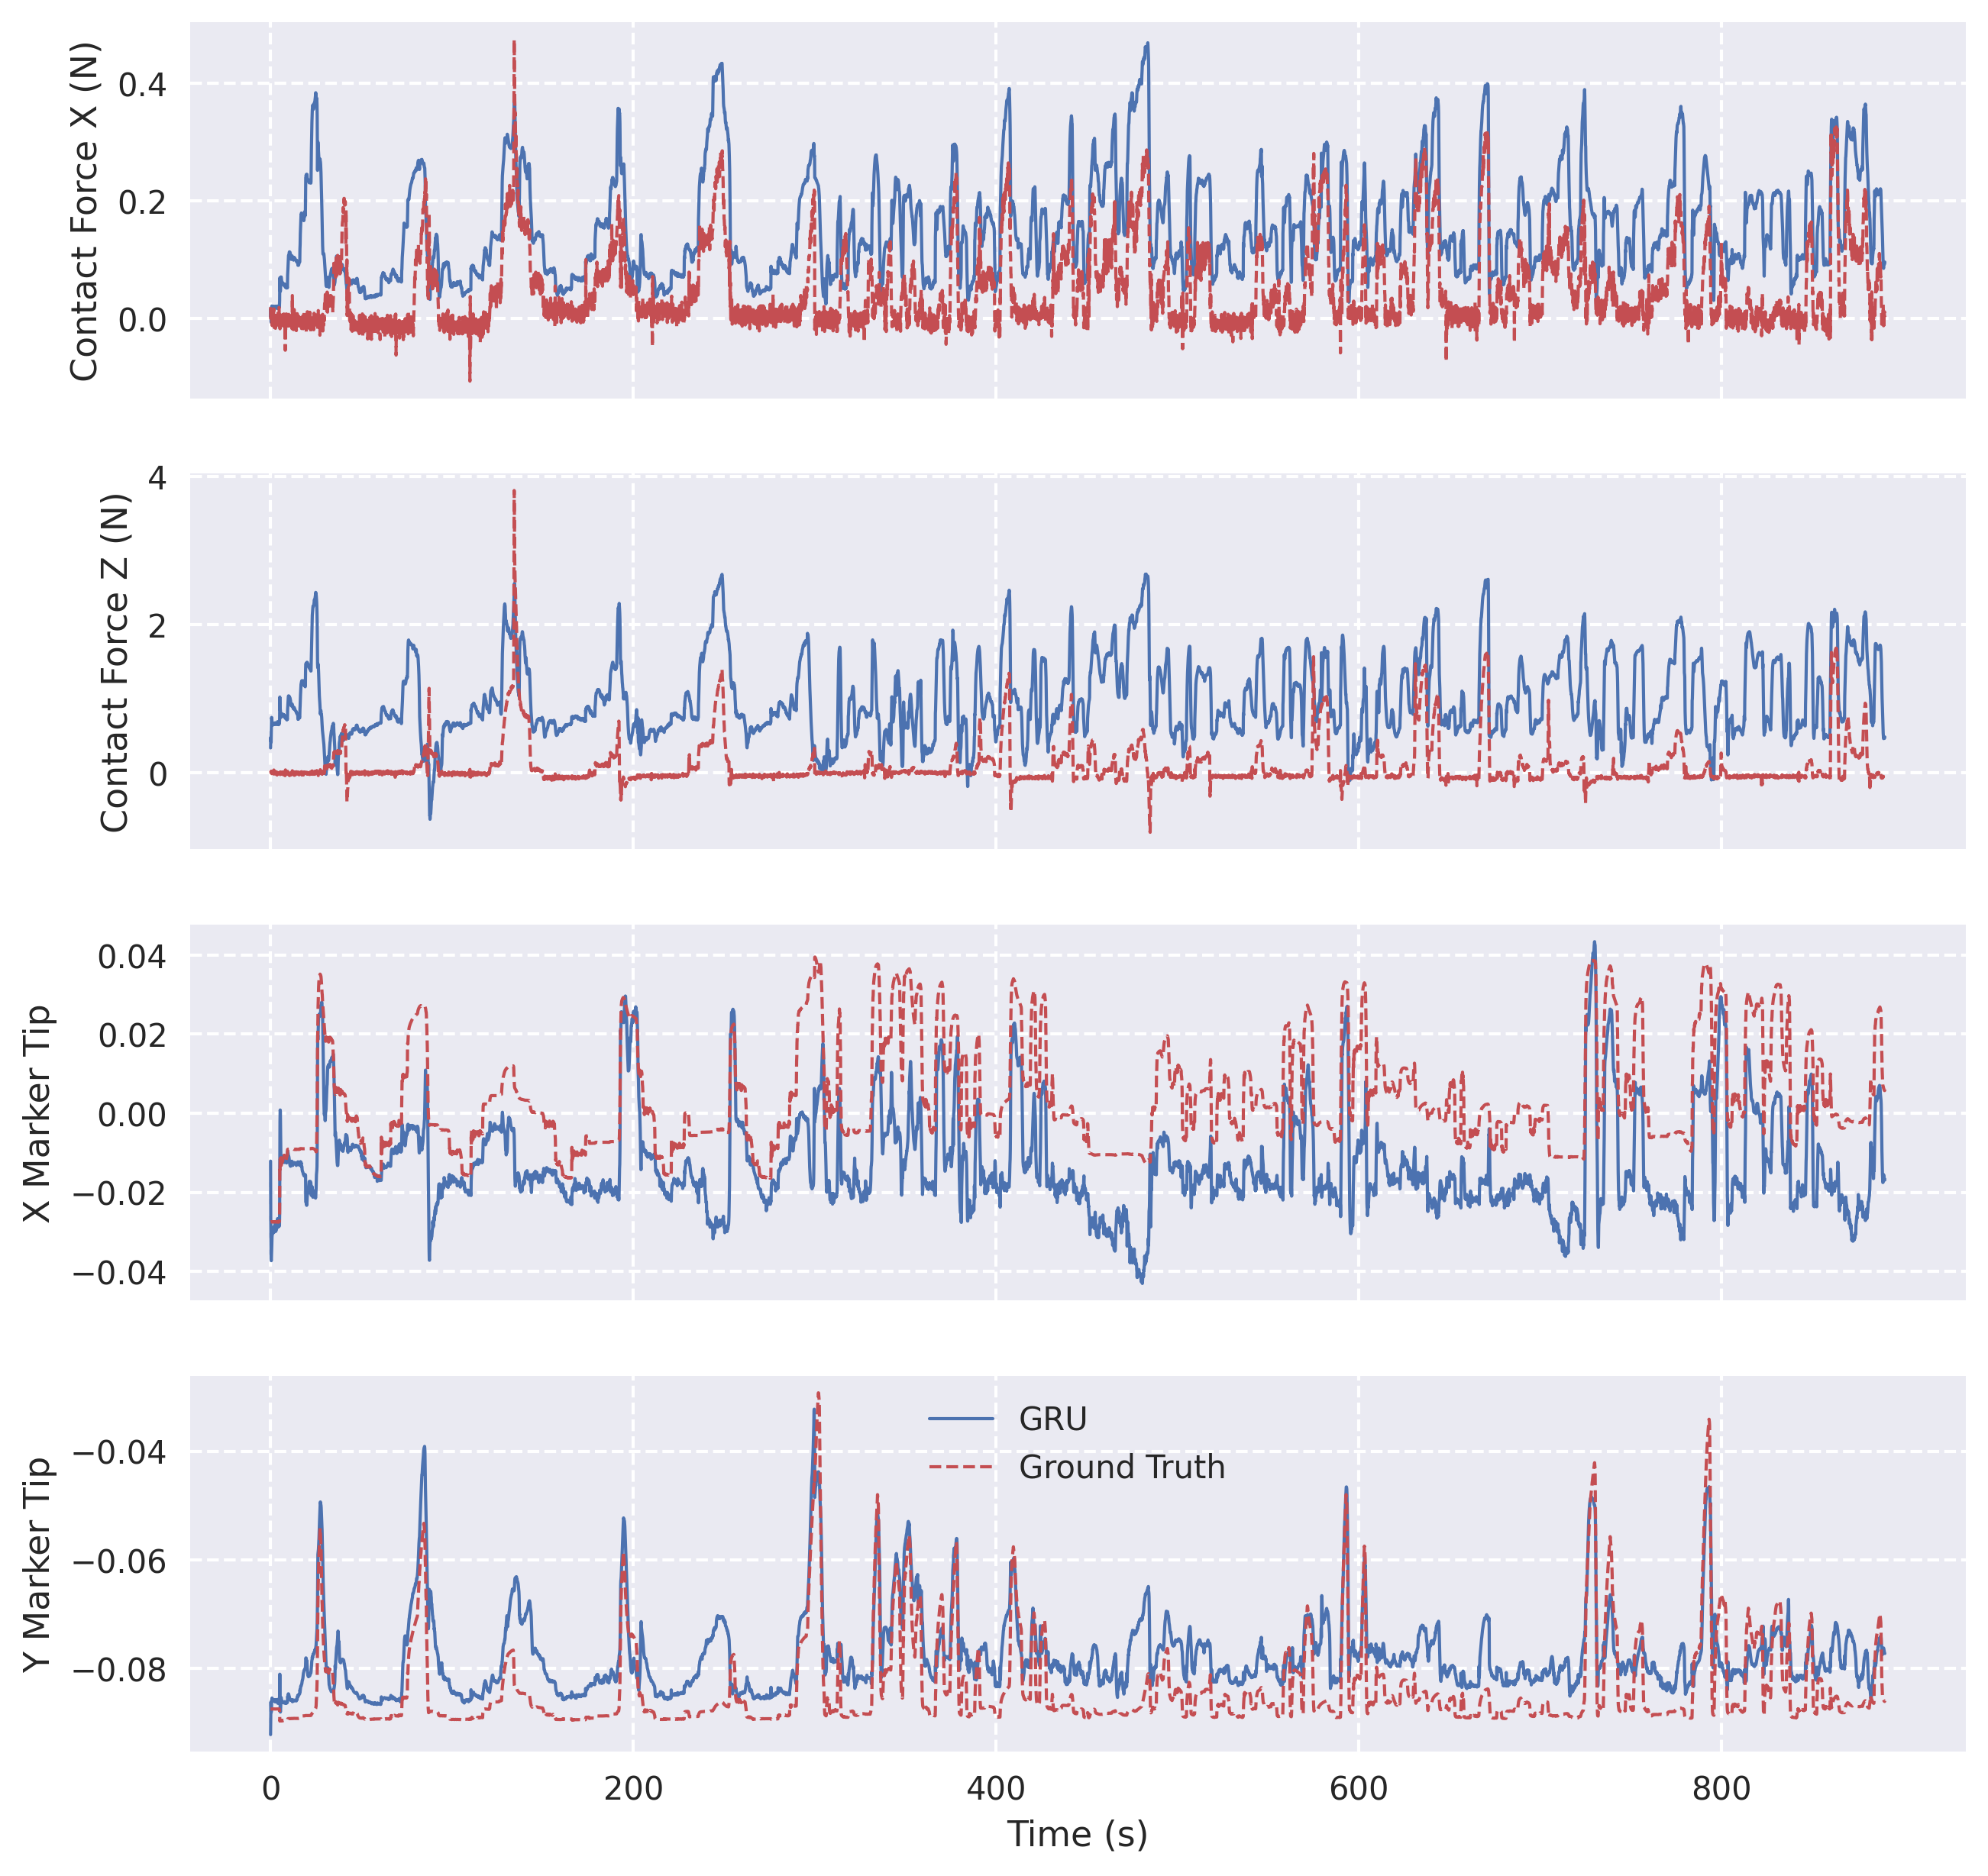

In [28]:
import seaborn as sns

y_test = []
for step, (x_batch_test, y_batch_test, state_available) in enumerate(test_dataset):
    y_test.append(y_batch_test)

y_test = np.concatenate(y_test)

plotted_y_test = scalers[0].inverse_transform(revert_timeseries(y_test, timesteps))
# plotted_y_test = revert_timeseries(y_test, timesteps)


force_labels_x = plotted_y_test[:, 0]
force_labels_z = plotted_y_test[:, 1]  
x_tip = plotted_y_test[:, 11]
y_tip = plotted_y_test[:, -1]


labels_arr = [force_labels_x, force_labels_z, x_tip, y_tip]
x_title = ["Force X (N)", "Force Z (N)", "X Tip", "Y Tip"]

f, (a1,a2,a3,a4) = plt.subplots(4,1,sharex=True, figsize=(10,10), dpi=300)
# f, (a1,a2,a3,a4) = plt.subplots(4,1,sharex=True)  

a1.set_ylabel('Contact Force X (N)')
a2.set_ylabel('Contact Force Z (N)')
a3.set_ylabel('X Marker Tip')
a4.set_ylabel('Y Marker Tip')

x = 0.1*np.arange(np.shape(plotted_y_test)[0])

axes = (a1, a2, a3, a4)
labels = ["GRU"]

ESTIMATIONS = []
c = [sns.color_palette()[0], sns.color_palette()[4], sns.color_palette()[1]]
for i, model in enumerate([GRU]):
    ESTIMATIONS.append(plot(axes, model, l=labels[i], vrnn=True if labels[i] == "DSVB" else False, color=c[i]))
    
a1.plot(x,labels_arr[0], color=sns.color_palette()[2], linestyle="--", label='Ground Truth', linewidth=1)
a1.grid(linestyle = '--',)

a2.plot(x, labels_arr[1], color=sns.color_palette()[2], linestyle="--", label='Ground Truth', linewidth=1)
a2.grid(linestyle = '--',)

a3.grid(linestyle = '--',)
a3.plot(x, labels_arr[2],color=sns.color_palette()[2],  linestyle="--", label='Ground Truth', linewidth=1)

a4.grid(linestyle = '--',)
a4.plot(x, labels_arr[3], color=sns.color_palette()[2], linestyle="--", label='Ground Truth', linewidth=1)

a4.set_xlabel("Time (s)")
    
# a1.legend()
# a2.legend()
# a3.legend()
a4.legend()
# plt.savefig("estimations.png")
plt.show()
